In [35]:
"https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0"
"https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html"

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import gensim
from tqdm import tqdm
from nltk.corpus import stopwords

plt.style.use('seaborn')

#data_path = "data/santiago_covid_2020.csv"
#data_path = "data/santiago_enero.csv"
data_path = "data/gabrielboric.csv"



# spanish stop words
stop_words = set(stopwords.words('spanish'))
stop_words = ['t', 'si', 'q', 'https', 'co', 'solo', 'ser', 'bien', 
            'así', 'ma', 'mas', 'igual', 'va', 'después',
            'hacer', 'hace', 'creo'] + list(stop_words)

# **Métodos útiles**

In [155]:
def bar_plot(x, y, title, file_name):
    """useful method to generate and save bar plots.

    Args:
        x (str, float?): names.
        y (float): value of each name.
        title (str): title to put on the plot.
        file_name (str): fiel name to save the plot
    """
    plt.bar(x, y)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.savefig("imgs/segunda_avance/" + file_name)
    plt.show()

def delete_chars(text, unwanted_chars):
    """
    useful method to replace a list of chars on text.
    return:
        (str) the same str without the chars in chars.
    """
    for char in unwanted_chars:
        text = text.replace(char, '')
    return text

def preprocess_tweet(tweet):
    """
    Replaces unwanted characters and performs
    a preprocessing.
    input: 
        (str) tweet.
    return:
        (str[]) final: list of words.
    """
    unwanted = ['#', ',', '.', '!', '?', '¿', '¡', '(',\
                ')', '-', '=', 'jaja', 'jajaja']
    final = delete_chars(tweet, unwanted).split()
    final = [w.lower() for w in final]
    # Asumo que no hay @´s de dos caracteres como @ho.
    final = [w for w in final if w not in stop_words and len(w) > 3]
    # Se eliminan links
    final = [w for w in final if w[:4] != 'http']
    #final = [w for w in final if w[:1] != '@']
    return final
    
# mini mini test
print(preprocess_tweet('##hola) ¿chao? =) jaja! @jaja_ja'))


['hola', 'chao', '@_ja']


# **Tweets**

In [149]:
# Raw data, no pre-process yet.
# 3756 días.

data = pd.read_csv(data_path)[['date', 'tweet']]
print('---------------------------------------------------------')
print('Sample: ', data.iloc[0]['tweet'])
print('---------------------------------------------------------')
print('Cantidad de tweets basal: ', len(data))
print('---------------------------------------------------------')
print('Sample: ')
# Manejamos el formato de las fechas en data. Correr sólo una vez esta celda.
data.index = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in data['date']]
data.drop('date', axis=1, inplace=True)
data.head(5)

C:\Users\jigna\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (9,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


---------------------------------------------------------
Sample:  Hoy nos reunimos con el Rector de la @uvalpochile @ocorralesj para conversar sobre educación superior y los desafíos de las universidades estatales para el nuevo Chile. Nuestro gobierno buscará fortalecer la #educación pública de calidad.  https://t.co/aXvXMWoNPx
---------------------------------------------------------
Cantidad de tweets basal:  39405
---------------------------------------------------------
Sample: 


,tweet
2021-06-30,Hoy nos reunimos con el Rector de la @uvalpoch...
2021-06-30,Muy bien! Estamos en la misma en Magallanes ;)
2021-06-30,@valerialunacs @SergioIbacache Esta reservada ...
2021-06-30,@andresazocar Hola Andrés. Tengo muy integrado...
2021-06-30,Hoy también estaré conversando (y aprendiendo)...


In [150]:
# Agrupación cada 7 días.
seven_days = data.groupby([data.index]).count().resample('W').sum()


print('----------------------------------------------------------------')
print('Agrupación de tweets cada 7 días: ')
print('Mean = {}'.format(seven_days.mean().to_string(index=False)))
print('Min = {}'.format(seven_days.min().to_string(index=False)))
print('Max = {}'.format(seven_days.max().to_string(index=False)))

seven_days


----------------------------------------------------------------
Agrupación de tweets cada 7 días: 
Mean =  63.969156
Min =  0
Max =  379


,tweet
2009-09-20,4
2009-09-27,2
2009-10-04,3
2009-10-11,0
2009-10-18,2
...,...
2021-06-06,76
2021-06-13,76
2021-06-20,69
2021-06-27,98


----------------------------------------------------------------
Agrupación de tweets por año: 
Mean =  3031.153846
Min =  48
Max =  6904


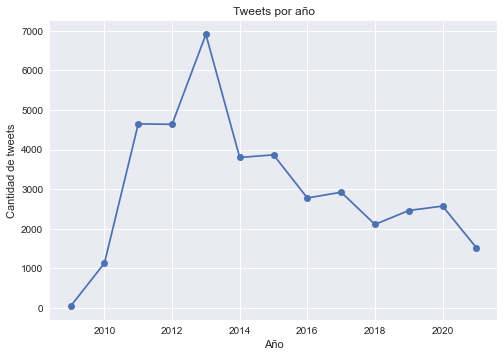

In [147]:
# Agrupación de tweets por año.

per_year = data.groupby([data.index.year]).count()
plt.plot(per_year.index, per_year['tweet'], '-o')
#for (x, y) in zip(daily.index, daily['tweet']):
#    plt.annotate('{}'.format(y), (x, y), xytext=(10,10), textcoords='offset pixels')
plt.title('Tweets por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de tweets')
#plt.savefig('imgs/boric_tweet_año.png')


print('----------------------------------------------------------------')
print('Agrupación de tweets por año: ')
print('Mean = {}'.format(per_year.mean().to_string(index=False)))
print('Min = {}'.format(per_year.min().to_string(index=False)))
print('Max = {}'.format(per_year.max().to_string(index=False)))

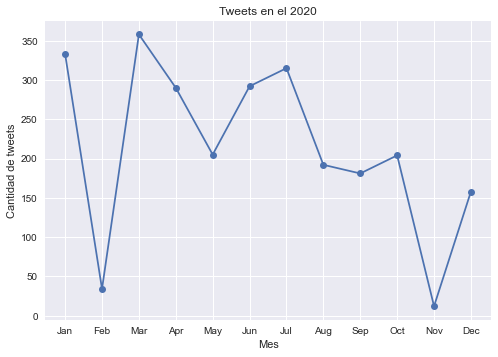

In [118]:
# Agrupación y tweets por mes.

per_month = data.groupby([data.index.year, data.index.month]).count()
only_2020 = per_month.loc[2020]

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(months, only_2020, '-o')
plt.title('Tweets en el 2020')
plt.xlabel('Mes')
plt.ylabel('Cantidad de tweets')
#plt.savefig('imgs/boric_tweet_2020.png')

In [7]:
# teting preprocess_tweet method on the first tweet.
preprocess_tweet(data.iloc[0]['tweet'])

['reunimos',
 'rector',
 '@uvalpochile',
 '@ocorralesj',
 'conversar',
 'educación',
 'superior',
 'desafíos',
 'universidades',
 'estatales',
 'nuevo',
 'chile',
 'gobierno',
 'buscará',
 'fortalecer',
 'educación',
 'pública',
 'calidad']

# **Preprocess**

In [8]:
# Se pre-procesan los tweets: Esto transforma cada
# tweet en una colección de palabras.
# processed_tweets corresponde a una lista de listas de palabras.

processed_tweets = data['tweet'].map(preprocess_tweet)
processed_tweets.head()

# Se van a eliminar tweets pequeños: con menos de 5 palabras después
# del preprocessing.
dropers = []
for ind, tweet in enumerate(processed_tweets):
    if len(tweet) < 5:
        dropers.append(ind) 

processed_tweets = processed_tweets.drop(dropers)
print(processed_tweets.sample(5))

print("-----------------------------------------------------------------")
print('Cantidad de tweets resultantes: ', len(processed_tweets))

34446    [@ccarimansantana, @panchofigueroa, @creaizqui...
6253     [@magonzalezna, contrato, reino, españa, oblig...
22164    [cierto, vengo, llegando, antártica, parte, di...
1693     [ayer, aprobó, comisión, senado, escaños, rese...
13939    [@javiert51, ahora, corredora, propiedades, no...
Name: tweet, dtype: object
-----------------------------------------------------------------
Cantidad de tweets resultantes:  24218


In [10]:
# Se crea el vocabulario. 
# Corresponde a crear una lista con todas las palabras involucradas 
# en el corpus asignando un índice único a cada una.

dictionary = gensim.corpora.Dictionary(processed_tweets)

c = 0
for k, v in dictionary.iteritems():
    print(k,v)
    c += 1
    if c > 5: break

print("-----------------------------------------------------------------")
print('Largo del diccionario: ', len(dictionary))
print("-----------------------------------------------------------------")

0 @ocorralesj
1 @uvalpochile
2 buscará
3 calidad
4 chile
5 conversar
-----------------------------------------------------------------
Largo del diccionario:  35892
-----------------------------------------------------------------


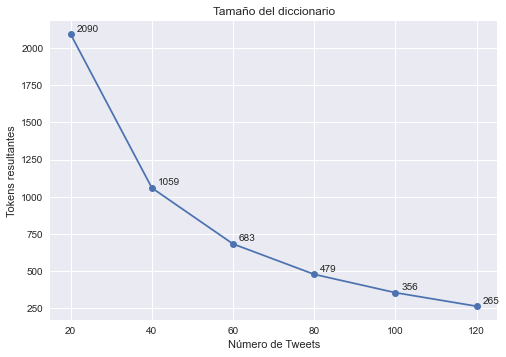

In [68]:
# Acá se filtran tokens:

# Se quitan palabras que aparecen en menos de 20 tweets y las
# que aparecen en más del 50% del total de tweets (?).

no_belows = [20, 40, 60, 80, 100, 120]
dict_len = [] 


for n in no_belows:
    # Se crea un dict en cada iteración.
    dictionary = gensim.corpora.Dictionary(processed_tweets)
    # Se filtra el dict.
    dictionary.filter_extremes(no_below=n, no_above=1)
    # Se guarda el len.
    dict_len.append(len(dictionary))

# Plot del largo del diccionario en función del no_below.
plt.plot(no_belows, dict_len, '-o')
for (x, y) in zip(no_belows, dict_len):
    plt.annotate('{}'.format(y), (x, y), xytext=(6,3), textcoords='offset pixels')
plt.title('Tamaño del diccionario')
plt.xlabel('Número de Tweets')
plt.ylabel('Tokens resultantes')
plt.savefig('imgs/no_below_len_dict.png')
plt.show()


In [15]:
# Se transforman las palabras a vectores con el dictionary.
# bow = "bag of words"

dictionary = gensim.corpora.Dictionary(processed_tweets)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_tweets]
i = 304
k = 666
print('bow tweet {}: \n'.format(i), bow_corpus[i])
print('bow tweet {}: \n'.format(k), bow_corpus[k])

# Con esto cada tweet se representa como una colección de tuplas (w, a) 
# donde w es el índice de la palabra y a la cantidad de apariciones en ese
# tweet.

bow tweet 304: 
 [(256, 1), (343, 1), (653, 1), (662, 1), (755, 1), (1078, 1), (1340, 1), (1457, 1), (1646, 1), (1650, 1), (1805, 1), (1862, 1), (1870, 1), (2263, 1), (2264, 1), (2295, 1), (2434, 1), (2435, 1), (2438, 1), (2454, 1), (2455, 1), (2456, 1)]
bow tweet 666: 
 [(4, 1), (10, 1), (273, 1), (445, 1), (492, 1), (733, 1), (752, 1), (769, 2), (1008, 1), (1011, 1), (1471, 1), (2274, 1), (4151, 1), (4152, 1), (4153, 1), (4154, 1)]


# **Boric0**

In [165]:
# Primera iteración del model: no se filtran tweets y se fijan parámetros
# al ojo. El parámetro 'passes' hace que se demore en correr.

from gensim.models import LdaModel

# Se crea el diccionario sin filtrar; modelo base.
dictionary = gensim.corpora.Dictionary(processed_tweets)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_tweets]

# Set training parameters.
num_topics = 5
chunksize = 2000
passes = 10
iterations = 50
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary#.id2token

lda_model = LdaModel(
    corpus=bow_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=1
)
# LdaMulticore


In [166]:
# Print de los tópicos y sus palabras.

for idx, topic in lda_model.print_topics(-1):
    print('TOPIC: {} \nWORDS: {}'.format(idx, topic))

TOPIC: 0 
WORDS: 0.010*"educación" + 0.009*"política" + 0.008*"chile" + 0.007*"acuerdo" + 0.006*"izquierda" + 0.006*"derecha" + 0.005*"gobierno" + 0.005*"puede" + 0.005*"mejor" + 0.005*"recomiendo"
TOPIC: 1 
WORDS: 0.010*"saludos" + 0.008*"@jschaulsohn" + 0.008*"@valenzuelalevi" + 0.007*"alguien" + 0.006*"@jparedesgodoy" + 0.005*"quiere" + 0.005*"marcha" + 0.004*"bueno" + 0.004*"mercurio" + 0.004*"trata"
TOPIC: 2 
WORDS: 0.014*"abrazo" + 0.013*"ahora" + 0.012*"magallanes" + 0.011*"buena" + 0.011*"mañana" + 0.010*"vamos" + 0.010*"fech" + 0.009*"arenas" + 0.008*"aguante" + 0.008*"punta"
TOPIC: 3 
WORDS: 0.013*"muchas" + 0.012*"gracias" + 0.010*"@jen_abate" + 0.008*"@matiasdelrio" + 0.008*"compa" + 0.007*"feliz" + 0.006*"concerta" + 0.006*"@saladehistoria" + 0.005*"concertación" + 0.005*"buenos"
TOPIC: 4 
WORDS: 0.012*"@cbellolio" + 0.010*"casa" + 0.008*"@lboric" + 0.007*"terrible" + 0.006*"facultad" + 0.006*"rector" + 0.006*"@donmatas" + 0.005*"universidades" + 0.005*"stgo" + 0.005*"supe

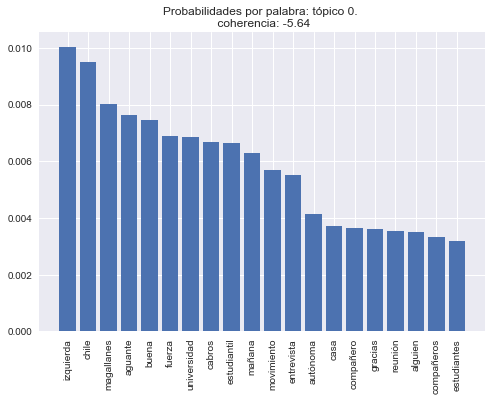

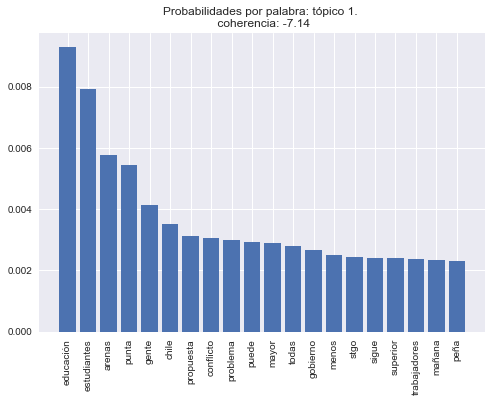

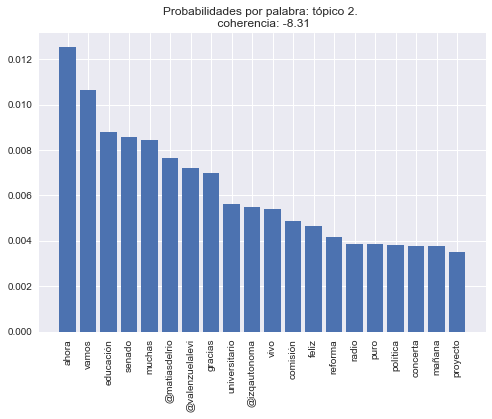

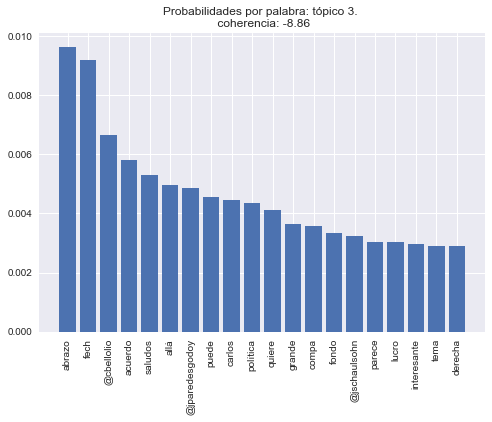

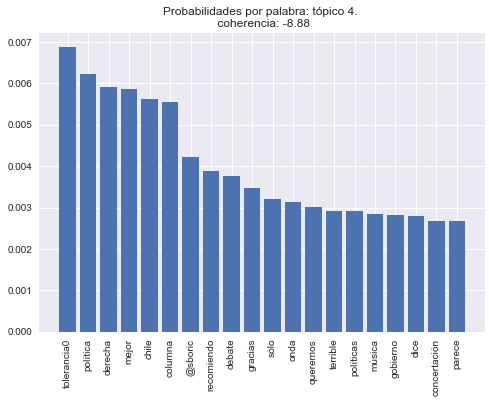

In [161]:
# Acá se generan bar plots de las probabilidades de cada palabra en los
# tópicos obtenidos.

# top_topics es un arreglo de tamaño el número de tópicos, cada elemento 
# de este arreglo es una tupla (arr, co) donde co es el valor de coherencia
# de cada tópico y arr es un arreglo de tuplas (prob, word) con la probab
# de cada palabra en el tópico. 

from pprint import pprint

top_topics = lda_model.top_topics(bow_corpus)#, num_words=20)

def bar_plot_boric():
    # Correr sólo para generar y guardar plots.
    for ind, t in enumerate(top_topics):
        bar_plot([x[1] for x in t[0]], [x[0] for x in t[0]], \
                "Probabilidades por palabra: tópico {}. \n coherencia: {}".format(ind, round(t[1],2)), \
                "boric_barplot{}.png".format(ind))
bar_plot_boric()


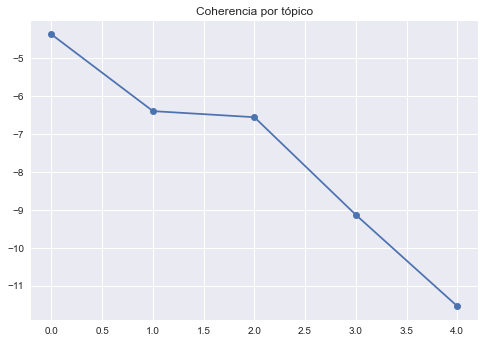

In [11]:
# Acá graficamos la coherencia por tópico.

plt.plot(range(len(top_topics)), [t[1] for t in top_topics], 'o-')
plt.title("Coherencia por tópico")
#plt.savefig("imgs/segunda_avance/boric_topic_coherence.png")
plt.show()

In [12]:
# Acá vamos a obtener el parámetro que guarda las probabilidades de cada tópico.
lda_model.get_topic_terms(0)

[(51, 0.047012854),
 (71, 0.03543868),
 (364, 0.02972899),
 (481, 0.018806858),
 (69, 0.017339677),
 (606, 0.01608522),
 (266, 0.015677817),
 (1574, 0.015518834),
 (1549, 0.015178222),
 (710, 0.014878581)]

In [13]:
# Visualizar:

#pyLDAvis.enable_notebook()
#pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

In [14]:
# En esta parte calculamos las métricas del modelo para calibrar
# hiperparámetros. Las métricas 'c_v' y 'c_uci' no funciona por el 
# broken pipe error. La métricaa 'u_mass' si funciona.

from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, \
                        texts=processed_tweets, \
                        dictionary=dictionary, \
                        coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()

print('\n Coherence Score: ', coherence_lda)

# Coherencia (u_mass) del base model: -6.085985154689787


 Coherence Score:  -7.603275075442181


In [15]:
# Method to calculate coherence measure for each hyperparamaters array.

def coherence_value(bow_corpus, dictionary, num_topics, alpha, eta):
    """Given the hyperparameters, computes a lda_model and calculates
    its 'u_mass' metric.

    Args:
        bow_corpus ([type]): List of tweets as bow
        dictionary ([type]): dictionary form of the corpus.
        num_topics (int): number of topics.
        alpha ([float]): a-priori belief for each topic probability. 
        eta ([float, float]): a-priori belief for words probabiliry
                                on each topic. 

    Returns:
        [float]: coherence measure 'u_mass'.
    """
    lda_model = LdaModel(corpus=bow_corpus,
                        id2word=dictionary,
                        chunksize=100,
                        alpha=alpha,
                        eta=eta,
                        num_topics=num_topics,
                        passes=10,
                        random_state=1)
    coherence_model_lda = CoherenceModel(model=lda_model,
                        texts=processed_tweets,
                        dictionary=dictionary,
                        coherence='u_mass')
    return coherence_model_lda.get_coherence()



# mini test: print(coherence_value(bow_corpus, dictionary, 5, 'auto', 'auto'))


# Now we iterate the previuos function on a grid and save the each value
# on a dictionary.
results = {'num_topics': [],
            'alpha': [],
            'eta': [],
            'u_mass': []}

topics_arr = range(2, 10)
alpha_arr = np.arange(0.01, 1, 0.3)
eta_arr = np.arange(0.01, 1, 0.3)

for num in tqdm(topics_arr):
    for alpha in alpha_arr:
        for eta in eta_arr:
            results['num_topics'].append(num)
            results['alpha'].append(alpha)
            results['eta'].append(eta)
            results['u_mass'].append(coherence_value(bow_corpus, dictionary, num, alpha, eta))


  0%|          | 0/8 [03:20<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
topics_arr = range(5, 11)
num_topics_umass = {'num_topics': [], 'umass': []}

for num_topics in tqdm(topics_arr):
    num_topics_umass['num_topics'].append(num_topics)
    num_topics_umass['umass'].append(coherence_value(bow_corpus, dictionary, num_topics, 'auto', 'auto'))




100%|██████████| 6/6 [02:29<00:00, 24.94s/it]


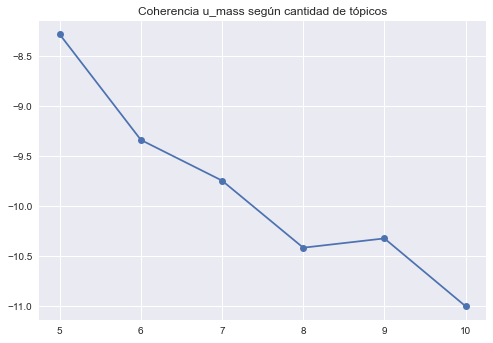

In [ ]:
plt.plot(num_topics_umass['num_topics'], num_topics_umass['umass'], 'o-')
plt.title('Coherencia u_mass según cantidad de tópicos')
plt.show()